In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import train_test_split
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.style.use('seaborn-poster')

warnings.filterwarnings('ignore')

In [2]:
king = pd.read_excel("..\data\king_county_home_sales.xlsx", index_col= "Unnamed: 0" )
king.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age,point,distance_to_starbucks_miles,distance_to_amazon_miles,distance_to_needle_miles
17530,9477000080,2014-07-14,415000,4,1.50,1540,7886,2.0,0,1540,...,7396,0,0,2,4,48,"(47.7731, -121.897)",24.385873,22.993861,23.583390
585,192460060,2014-07-15,330000,3,1.75,1510,15744,1.0,0,1510,...,15744,0,0,2,4,30,"(47.4025, -122.176)",14.396903,16.966174,17.105924
7326,7967600285,2014-12-11,449888,3,2.25,2520,78408,2.0,0,2520,...,29972,0,0,2,6,27,"(47.7011, -122.336)",8.313277,5.422008,5.602854


Here is a first attempt at a simple linear regression model using the sqft_living room of a home to model

In [3]:
# price as a function of sqfr_living room, this is just a pedigocial tool and will serve as a basis


X, y = king[['sqft_living']] , king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

# Init, fit, score
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Training score: {model.score(X_train, y_train)}")

print(f"Test score: {model.score(X, y)}")


Training score: 0.49217109776184653
Test score: 0.4926862289296692


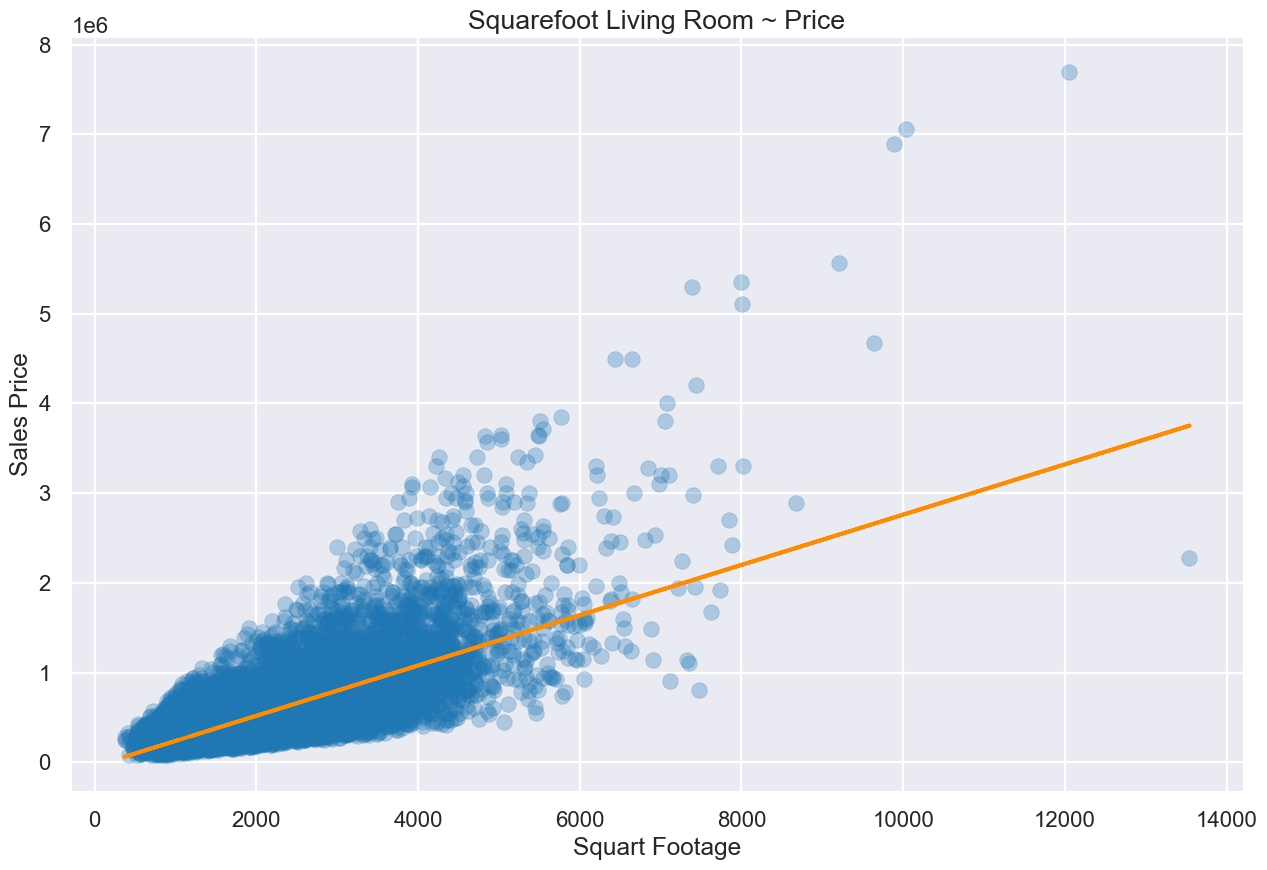

In [4]:
# plot fit
plt.scatter(king.sqft_living, king.price, alpha=0.3)
plt.plot(king.sqft_living, model.predict(king[['sqft_living']]), c='darkorange')
plt.title("Squarefoot Living Room ~ Price")
plt.xlabel("Squart Footage")
plt.ylabel("Sales Price")
plt.tight_layout()
plt.show()

Now it is time for a multi linear regression:

In [5]:
king.columns # calling all columns in order to determine what subset of columns we will use for our models
features = king[['bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'sqft_above',
                 'sqft_basement', 'lat', 'long', 'sqft_living15',
                 'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 'age', "renovated"]]

In [6]:
def correlated_column_names(df, target, threshold):
    # this function returns the a list of the names of columns with greater than a certain threshold of correlation. 
    index_columns = df.corr()[target][(df.corr()[target] >= threshold) & (df.corr()[target] != 1) ].index # this gets an index object
    columns = [index for index in index_columns] # this creates a list with column names 
    return(columns)

In [7]:
desirable = correlated_column_names(king, 'price', .3 )

In [8]:
X, y = king[desirable], king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.6411138377411928
Test score: 0.6353085725326941


In [9]:
# mulit model time: (all ~ price) decided to use every column here except for yr_built since this column and age are redundant and zipcode since it is an arbitraruy number not relevant to our dataframe yet.

X, y = features, king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.7008430929351751
Test score: 0.6837688709208767


An r^2 score of 0.68 isn't bad but it isn't great either. Maybe we have some collinearity issues going on and we need to be more selective about our features. So its time to do some feature selection

So how should we proceed from here? One step is to calculate the interactions between different features.

In [10]:
king.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', 'view_ord', 'condition_ord', 'grade_ord',
       'age', 'point', 'distance_to_starbucks_miles',
       'distance_to_amazon_miles', 'distance_to_needle_miles'],
      dtype='object')

In [11]:
y = king['price']
X = king[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
          'sqft_above', 'sqft_basement','lat', 'long', 'zipcode',
          'sqft_living15', 'sqft_lot15', 'renovated', 'view_ord', 'condition_ord', 'grade_ord', 'age']]

from sklearn.preprocessing import PolynomialFeatures

linear_withinteraction = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

X_transformed = linear_withinteraction.fit_transform(X.drop(columns= 'zipcode')) #removing zipcode column this will become evident latter when we dummy our zip code

feat_names = pd.Series(linear_withinteraction.get_feature_names())

feat_names

0           x0
1           x1
2           x2
3           x3
4           x4
        ...   
148    x13 x15
149    x13 x16
150    x14 x15
151    x14 x16
152    x15 x16
Length: 153, dtype: object

In [12]:
xs = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',  'x11', 'x12', 'x13', 'x14', 'x15','x16']

columns = X.columns

map_dict = {x:y for x,y in zip(xs, columns)}

for key, value in map_dict.items():
    feat_names = feat_names.str.replace(key, value)


X_trans_df = pd.DataFrame(X_transformed)
X_trans_df.columns = feat_names

In [13]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_trans_df, y, test_size=.3, random_state=42
)


# Init, fit, score
stand_model = LinearRegression()
stand_model.fit(X_train, y_train)

print(f"Training score: {stand_model.score(X_train, y_train)}")

print(f"Testing score: {stand_model.score(X_test, y_test)}")

stand_model_score  = stand_model.score(X_test, y_test)

Training score: 0.8049945871068767
Testing score: 0.7798931268737931


Now one last model except now with zip code as a dummied feature instead of as an integer value!

In [14]:
dummy_zip = pd.get_dummies(king['zipcode'], drop_first = True)

One more model with all of our features alongside dummied zip code data.

In [15]:
king.columns # calling all columns in order to determine what subset of columns we will use for our models

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', 'view_ord', 'condition_ord', 'grade_ord',
       'age', 'point', 'distance_to_starbucks_miles',
       'distance_to_amazon_miles', 'distance_to_needle_miles'],
      dtype='object')

In [16]:
features = king[['bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'sqft_above',
                 'sqft_basement', 'sqft_living15', 
                 'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 'age', "renovated"]]

In [17]:
features = features.join(dummy_zip)

X, y = features, king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.8108545552966462
Test score: 0.7982712839603738


Now we will incorporate the distance to downtown seattle in our model and compare the score! 

In [18]:
features = king[['bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'sqft_above',
                 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 
                 'age', "renovated", 'lat', 'long' ]]

In [19]:
features = features.join(dummy_zip)

X, y = features, king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.8110954608535189
Test score: 0.7983000063961335
